In [42]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import textblob

import data
import plot

In [2]:
train, test = data.get_data(use_cached=True)

Using Cached


# Goals of Exploration
- Plot some conversation samples
- Observe and explore why 3 of the major changes in conversations happened?
    - Topics
    - Replies

In [3]:
def _clean(string):
    string = string.lower()
    return string

def word_tokenize(string):
    return string.split(' ')

## Taking a look at a few random conversations

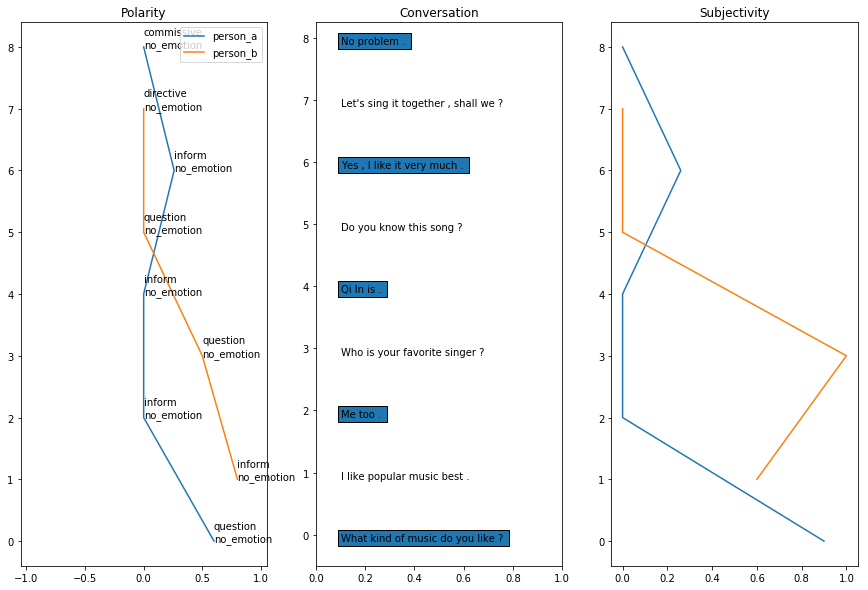

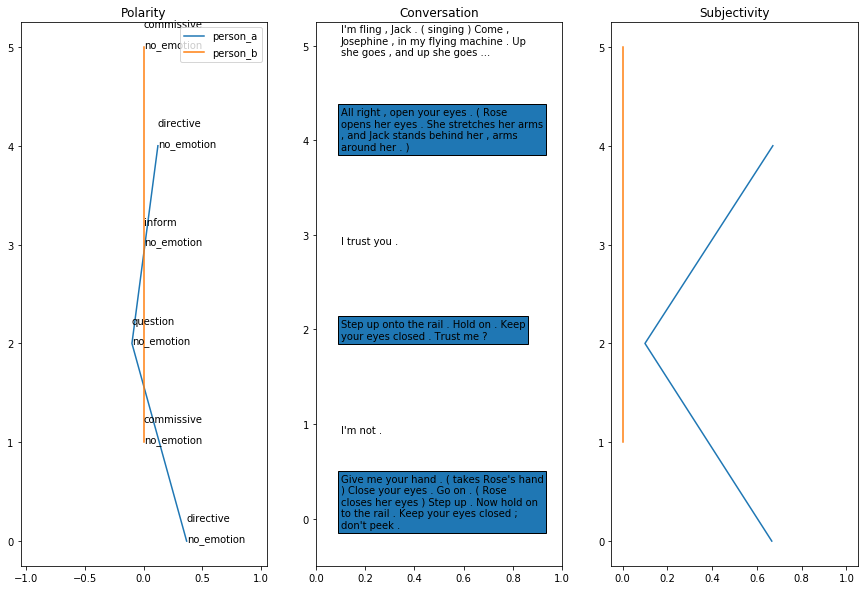

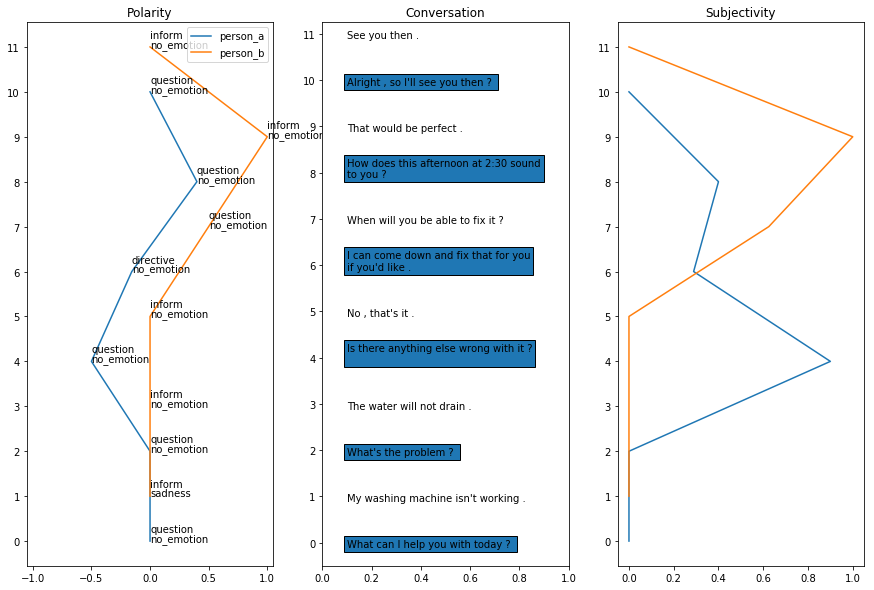

In [40]:
values = set(train.index.get_level_values(0))
num_convs = len(values)
conv_ids = np.random.randint(0, num_convs, 3)
for conv_id in conv_ids:
    plot.plot_conv(train.loc[conv_id])

## Looking at examples that had the largest change in sentiment (up and then down)

In [67]:
train['change_in_polarity'] = train.groupby([train.index.get_level_values(0), 'person'])['polarity'].diff()

shift_list = ['polarity', 'subjectivity', 'change_in_polarity', 'act', 'emo']
# shift_labels = ['heard_' + i for i in shift_list]
for label in shift_list:
    train['heard_' + label] = train.groupby([train.index.get_level_values(0)])[label].shift()

In [86]:
train = pd.concat([train, pd.get_dummies(train[['heard_act', 'heard_emo']])], axis=1)

In [31]:
def get_biggest_drawdown(s):
    "returns the largest net decrease in sentiment"
    i = np.argmax(np.maximum.accumulate(s) - s)
    j = np.argmax(s[:i])
    return s[i] - s[j]


def get_biggest_drawup(s):
    "returns the largest net increase in sentiment"
    i = np.argmin(np.minimum.accumulate(s) - s)
    j = np.argmin(s[:i])
    return s[i] - s[j]

In [87]:
# biggest_drawdown = train.groupby([train.index.get_level_values(0), 'person'])['polarity'].apply(get_biggest_drawdown)
# train.loc[train.sort_values('biggest_drawup', axis=0, ascending=False).index.get_level_values(0)
train['biggest_drawup'] = train.groupby([train.index.get_level_values(0), 'person'])['polarity'].transform(get_biggest_drawup)
train['biggest_drawdown'] = train.groupby([train.index.get_level_values(0), 'person'])['polarity'].transform(get_biggest_drawdown)

/Users/ryan/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)
/Users/ryan/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


In [95]:
num = 30

indices = list(train.sort_values('biggest_drawup', axis=0, ascending=False).index.get_level_values(0).unique())
biggest_drawup = train.loc[indices[:num]]

indices = list(train.sort_values('biggest_drawdown', axis=0, ascending=True).index.get_level_values(0).unique())
biggest_drawdown = train.loc[indices[:num]]

plt.close()

### EDA on top `num` Conversations that had the largest drawup in sentiment

From these plots it looks like there is some correlation between change in polarity between persons. 

Really, it would be best to just look at correlation between change in polarity and all other variables since we have them!

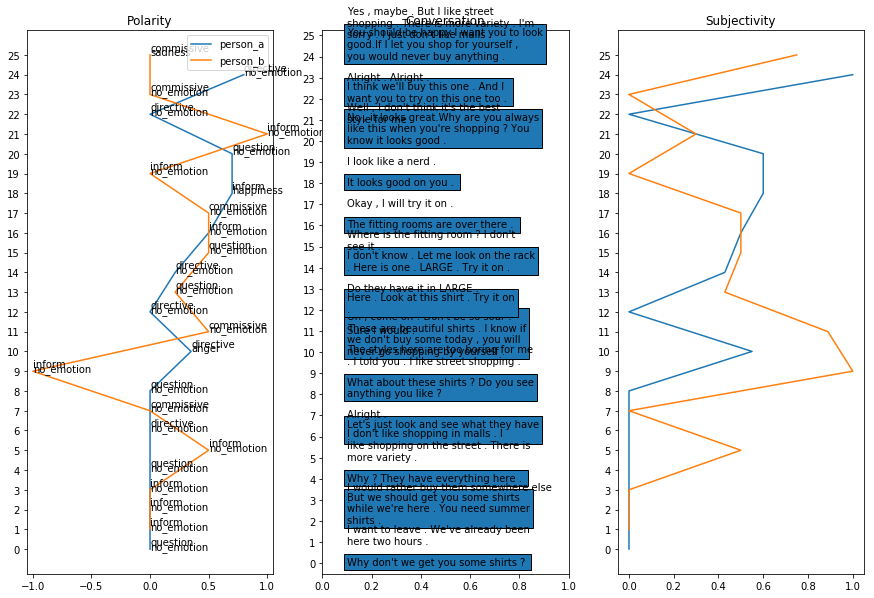

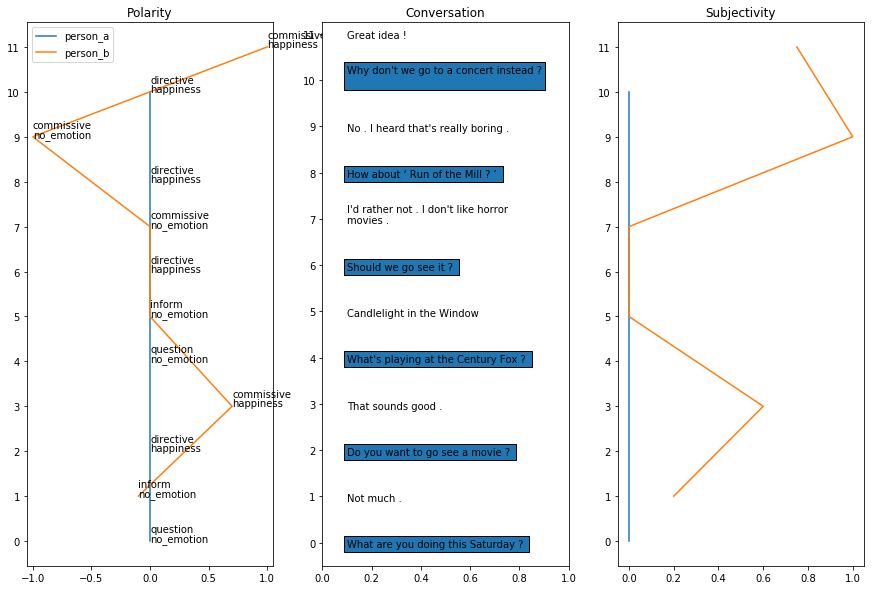

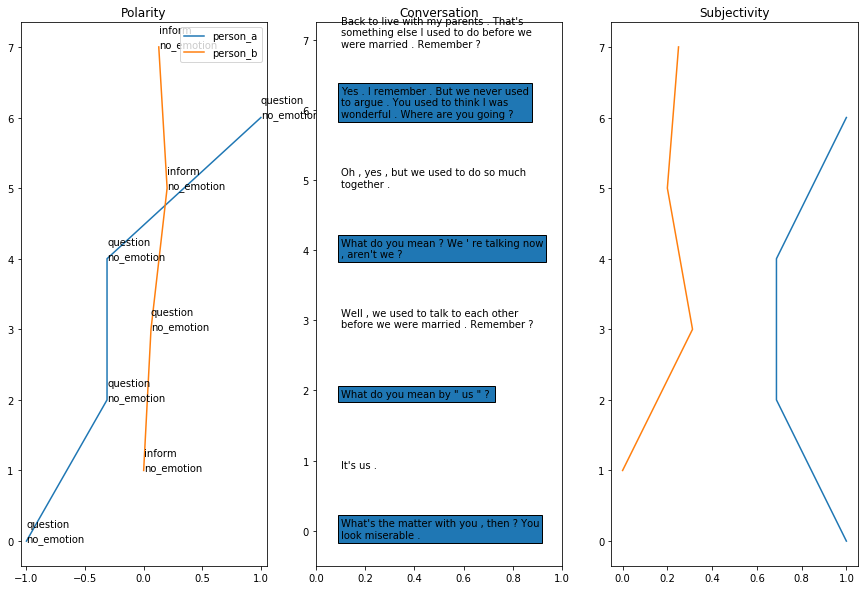

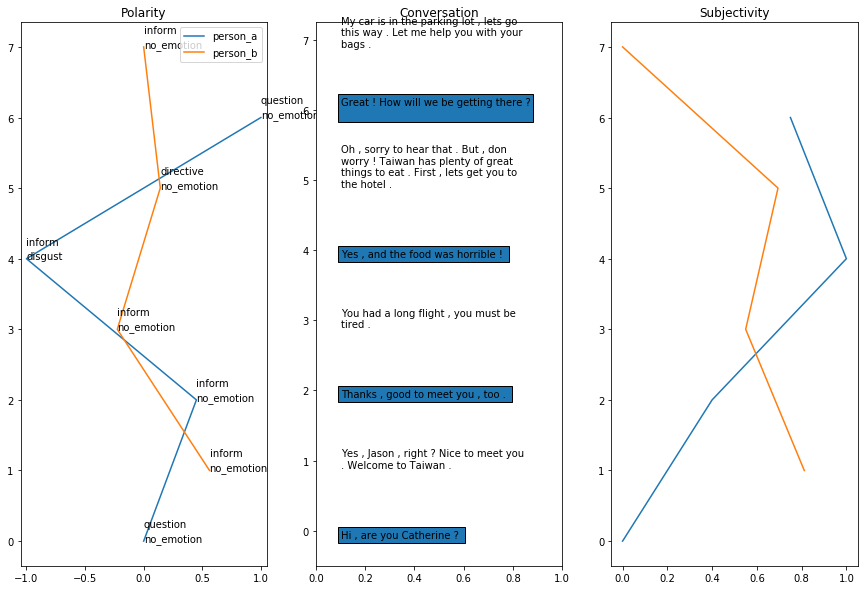

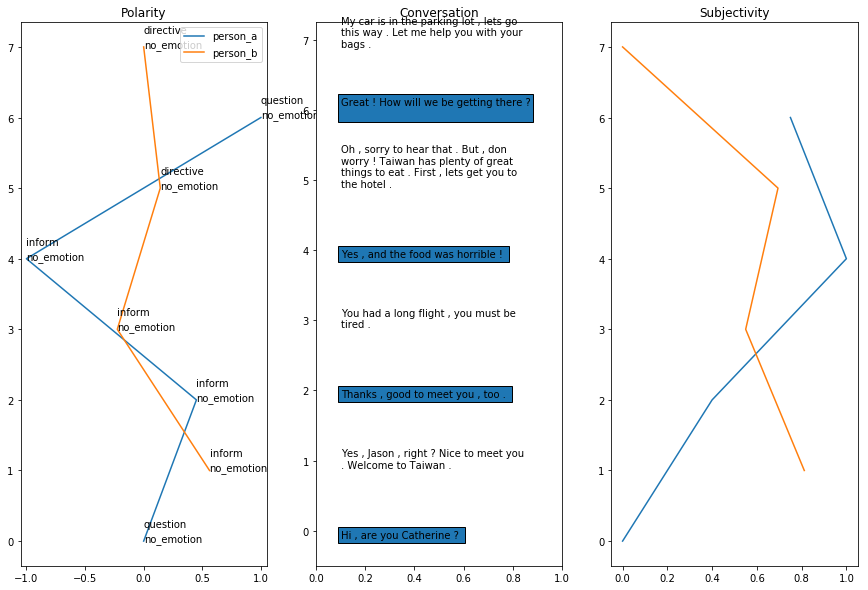

In [37]:
for loc in biggest_drawup.index.get_level_values(0).unique()[:4]:
    plot.plot_conv(biggest_drawup.loc[loc])

In [114]:
biggest_drawup.head(1)

,,person,utter,act,emo,polarity,subjectivity,topic,change_in_polarity,biggest_drawup,biggest_drawdown,...,heard_act_directive,heard_act_inform,heard_act_question,heard_emo_anger,heard_emo_disgust,heard_emo_fear,heard_emo_happiness,heard_emo_no_emotion,heard_emo_sadness,heard_emo_surprise
conv,,,,,,,,,,,,,,,,,,,,,,
47,0,person_a,My mother bought me a new video game .,inform,no_emotion,-0.131818,0.427273,ordinary_life,NaN,0.233333,-0.216667,...,0,0,0,0,0,0,0,0,0,0


### NOTE

`heard` prefix simply means that this is what the person heard; if the previous utterance had `no emotion | directive`, that is what would show up in this column.

#### corrplot

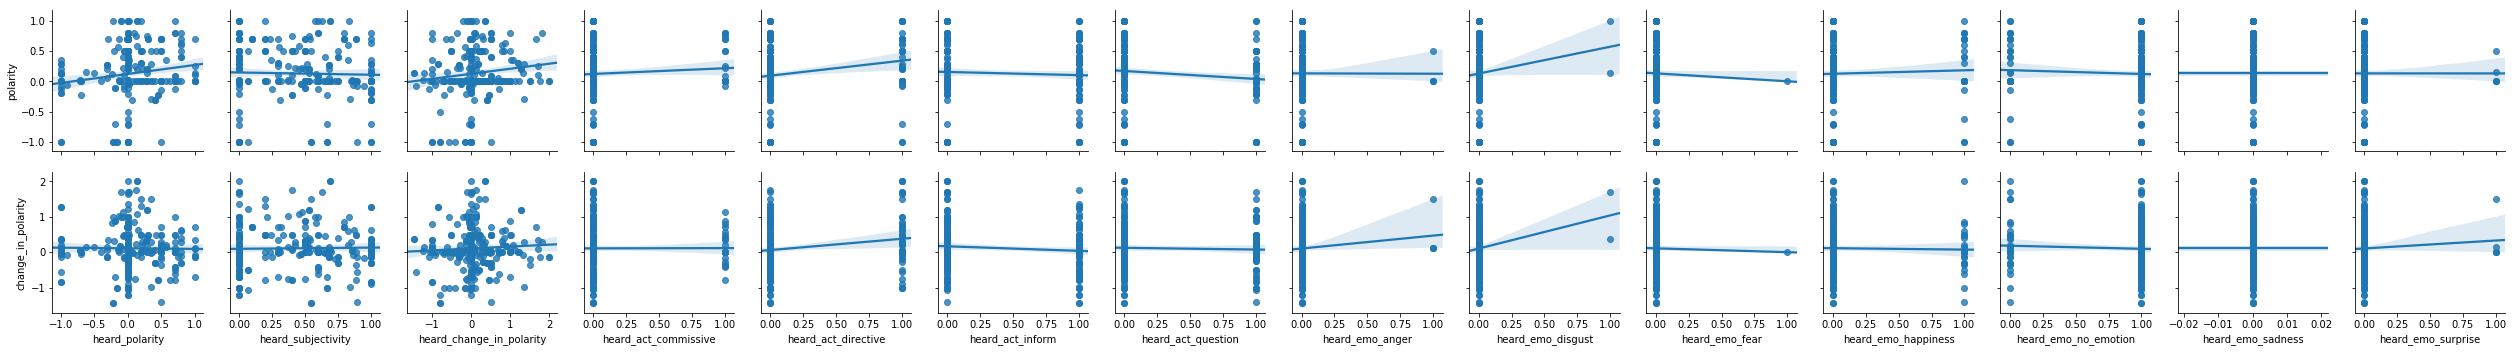

In [111]:
def corrplot(df):
    x_vars = [i for i in df.columns if 'heard_' in i and i != 'heard_act' and i != 'heard_emo']
    y_vars = ['polarity', 'change_in_polarity']
    sns.pairplot(df[y_vars + x_vars].dropna(),
                 kind='reg',
                 y_vars=y_vars,
                 x_vars=x_vars)
corrplot(biggest_drawup)

There's definitely SOME signal in there.

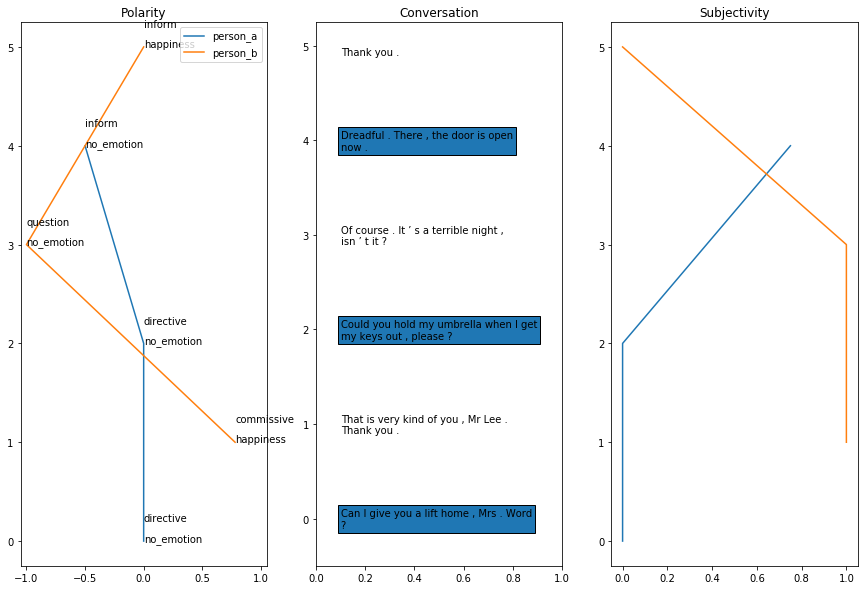

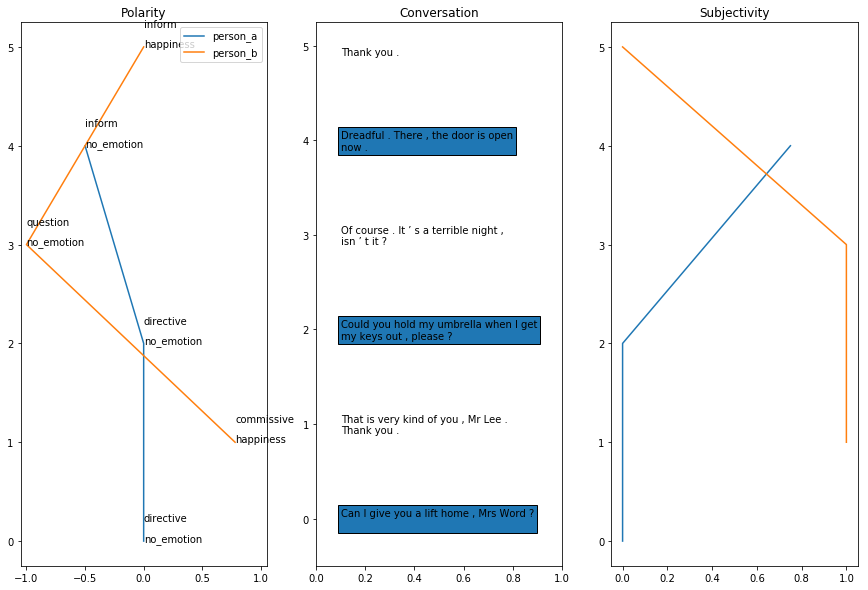

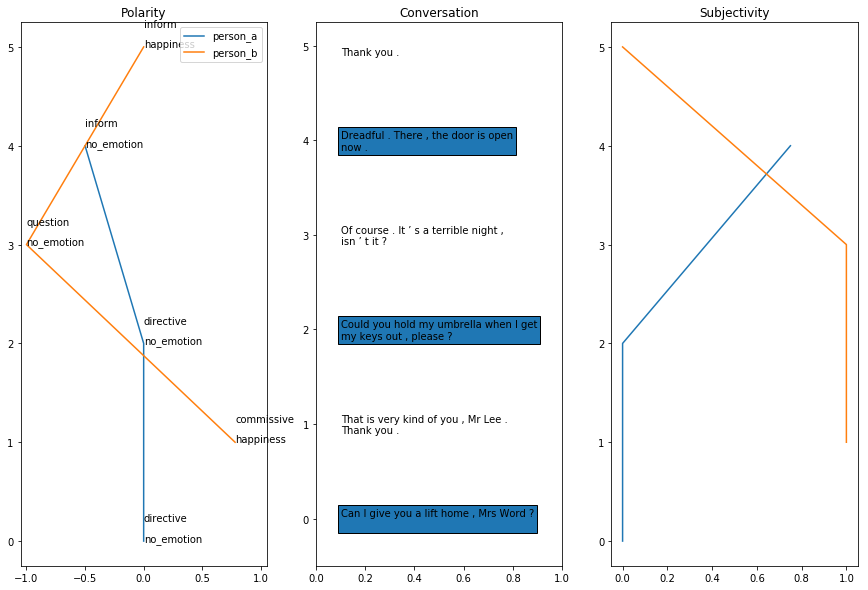

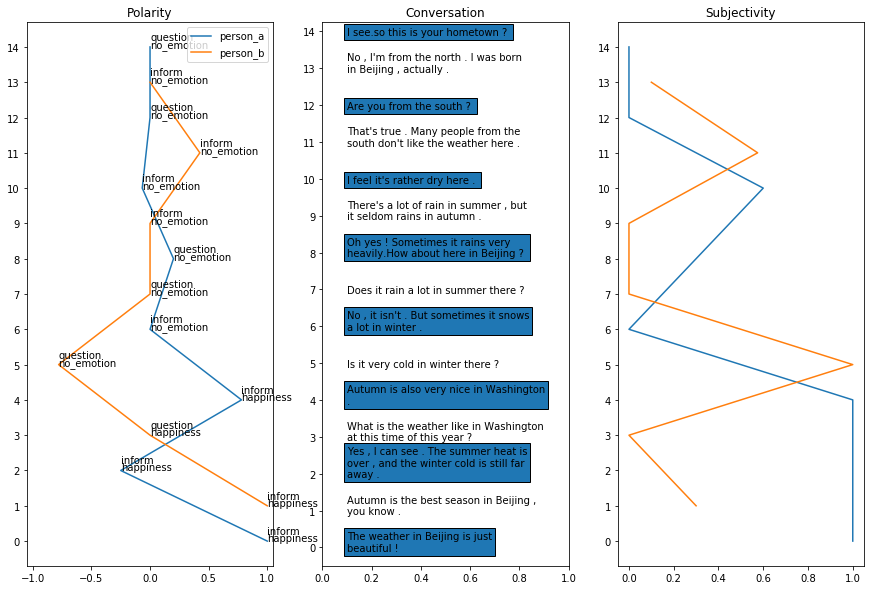

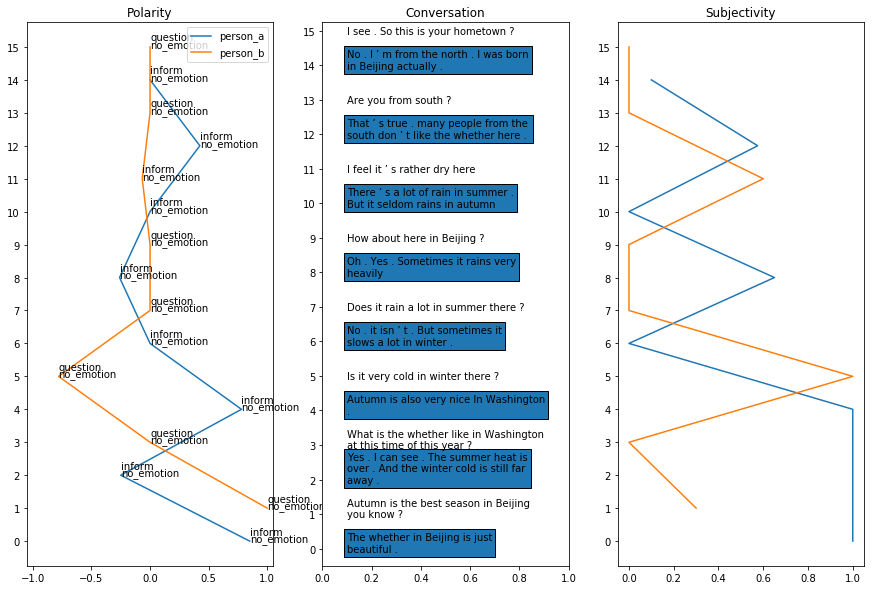

In [38]:
for loc in biggest_drawdown.index.get_level_values(0).unique()[:4]:
    plot.plot_conv(biggest_drawdown.loc[loc])

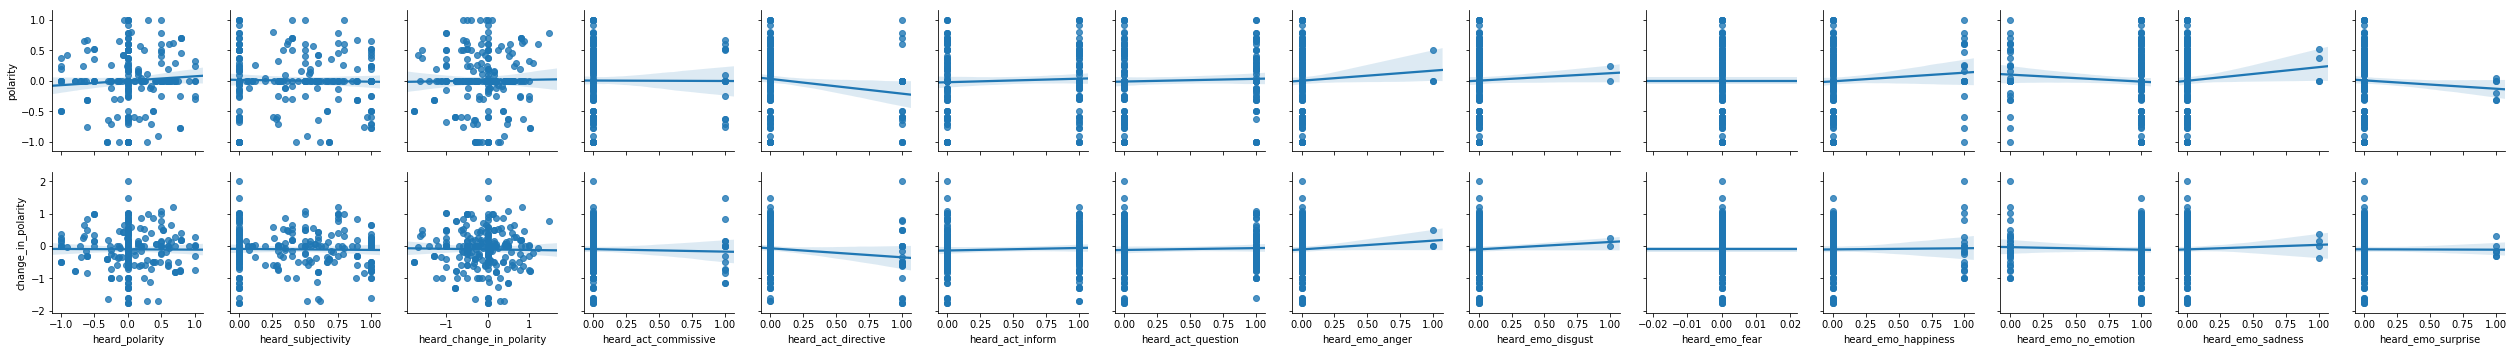

In [112]:
corrplot(biggest_drawdown)

### Take a look at random samples

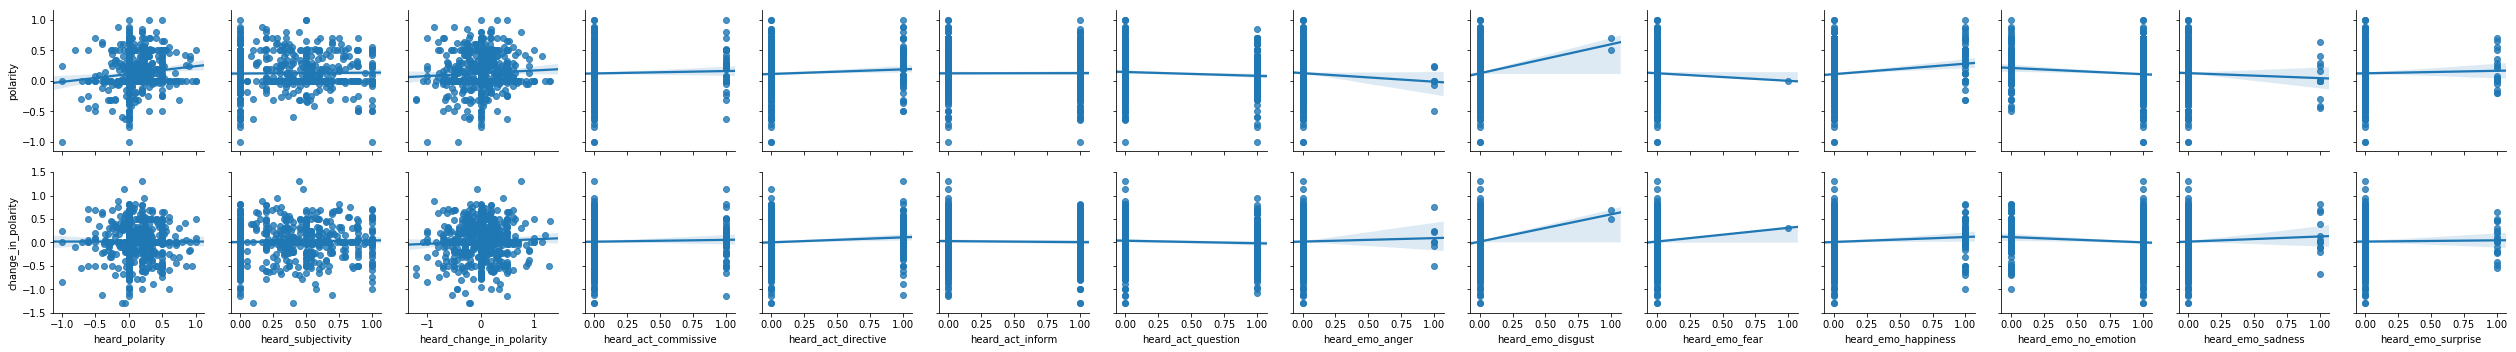

In [113]:
corrplot(train.sample(1000))

### Thoughts on observations

It looks like `heard_change_in_polarity` and `heard_polarity` (redundant obviously to some degree) both affect the next utterances polarity to some degree

It appears that most of the heard emotions and acts don't seem to have an effect en masse. This also doesn't consider all of the combinations of acts and emotions. 

The first two models I want to try are a linear model only including `heard_change_in_polarity` or `heard_polarity` (whichever has the largest effect. I will consider 

### Corrplots for various instances:
- each topic

### Modeling steps

There are so many combinations of categorical variables. It's seeming like now it makese sense to try either a RandomForest or GradientBoostedTree to get an idea about feature importance. 

In [116]:
topics = train['topic'].unique()

ordinary_life


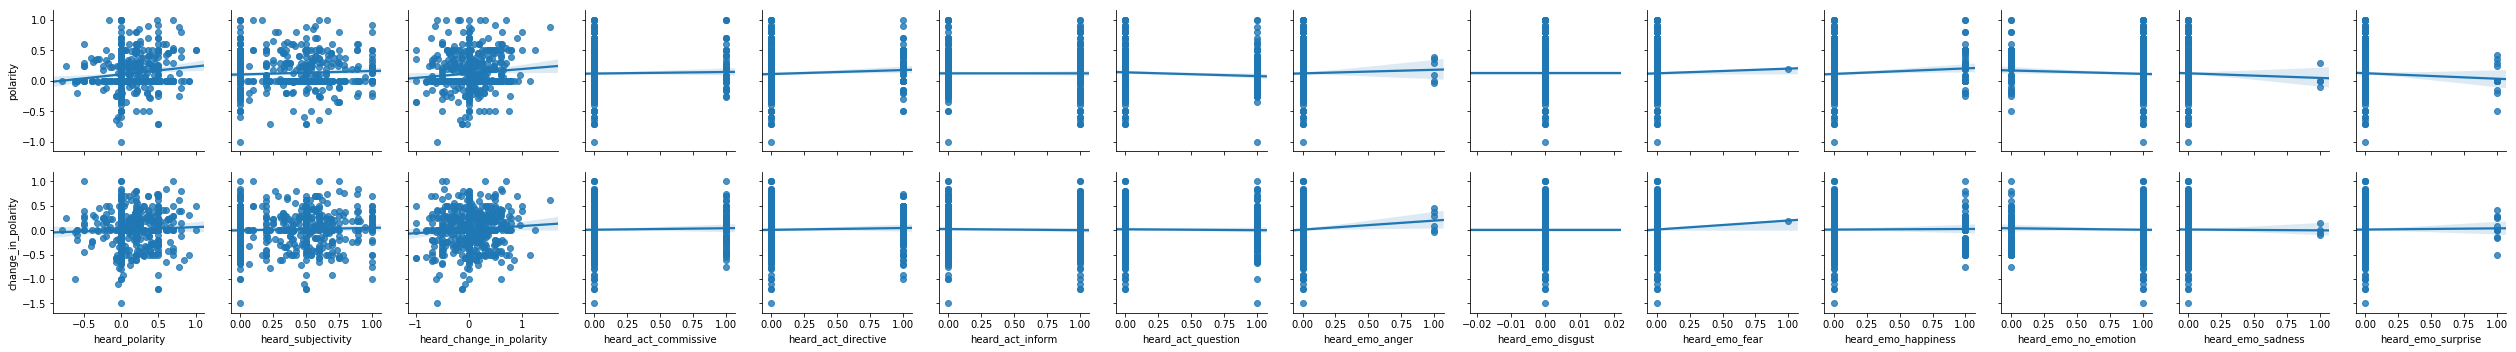

school_life


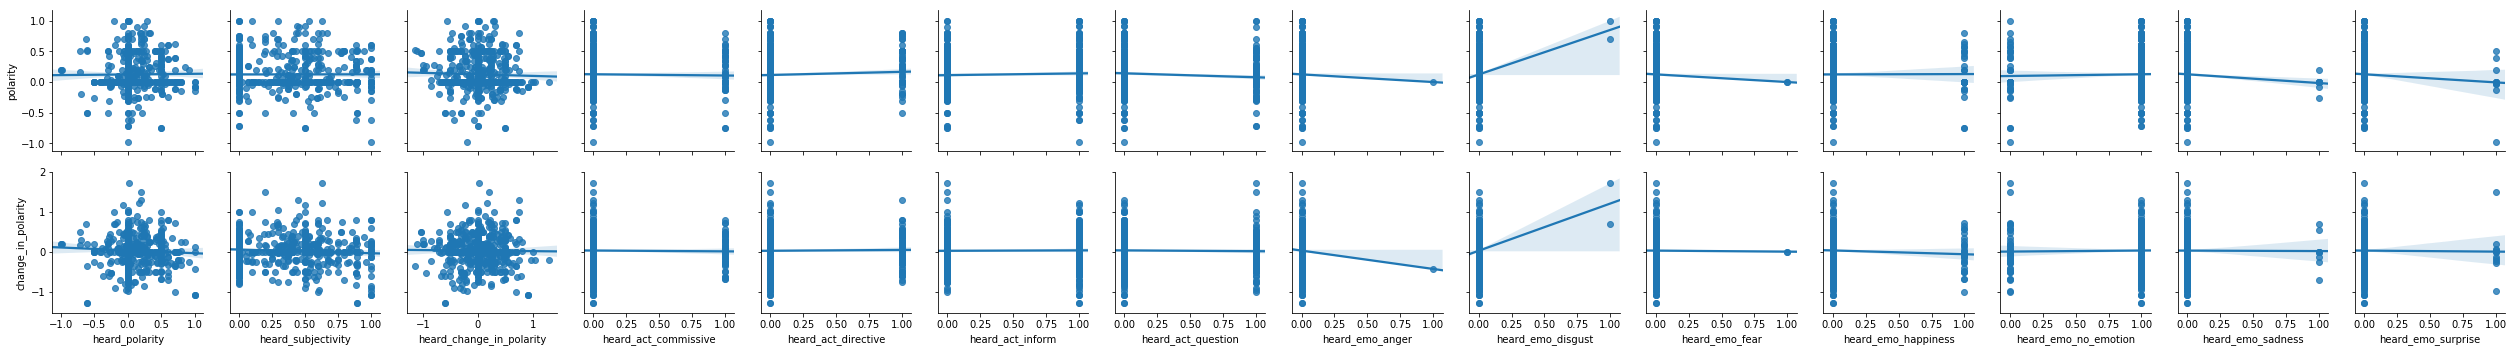

culture_education


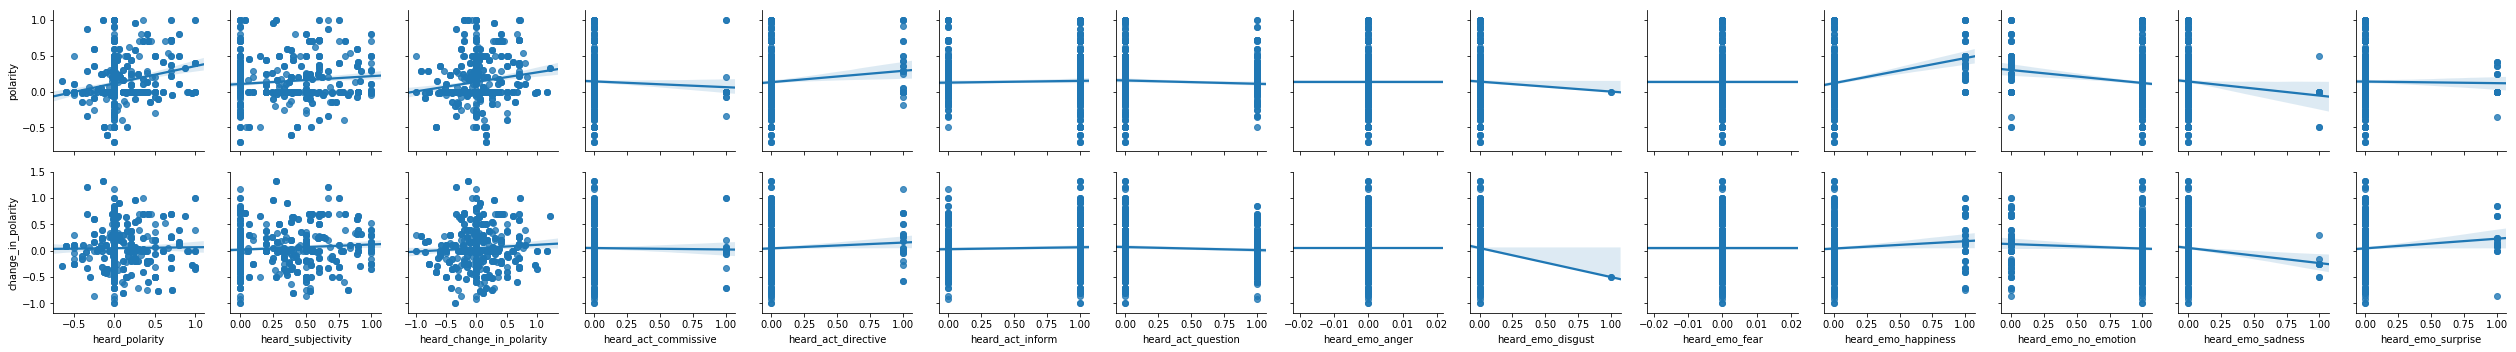

attitude_emotion


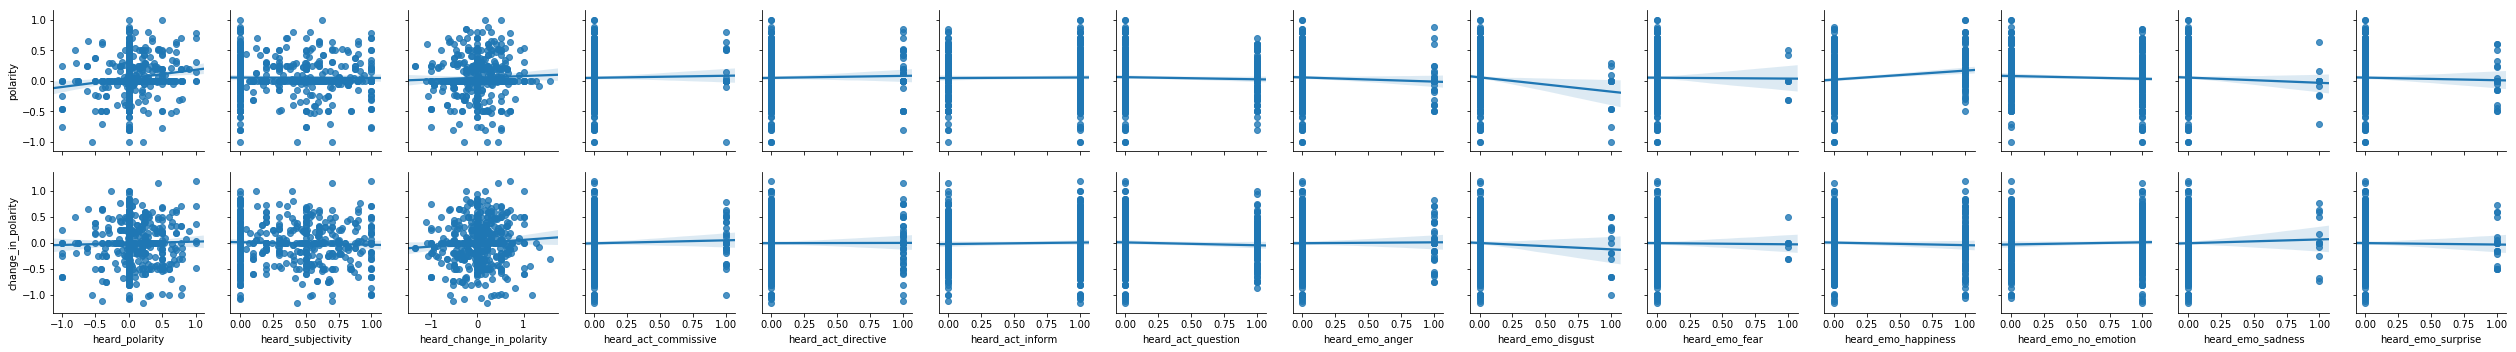

relationship


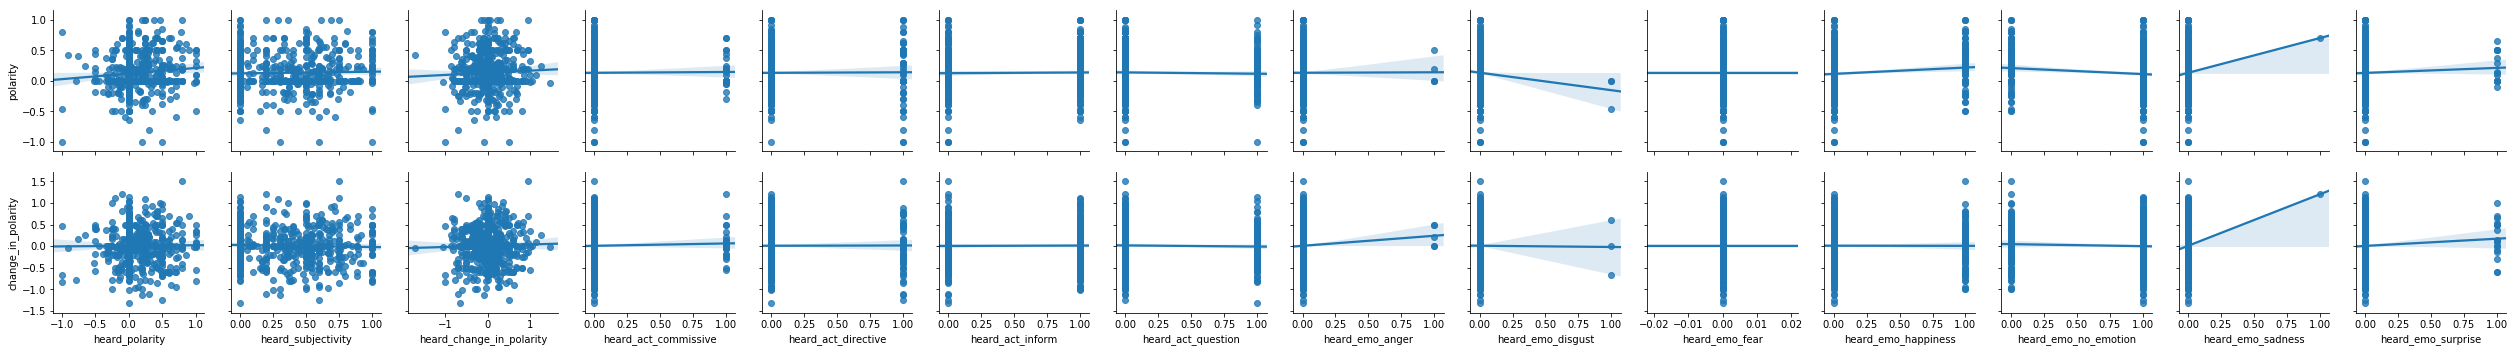

tourism


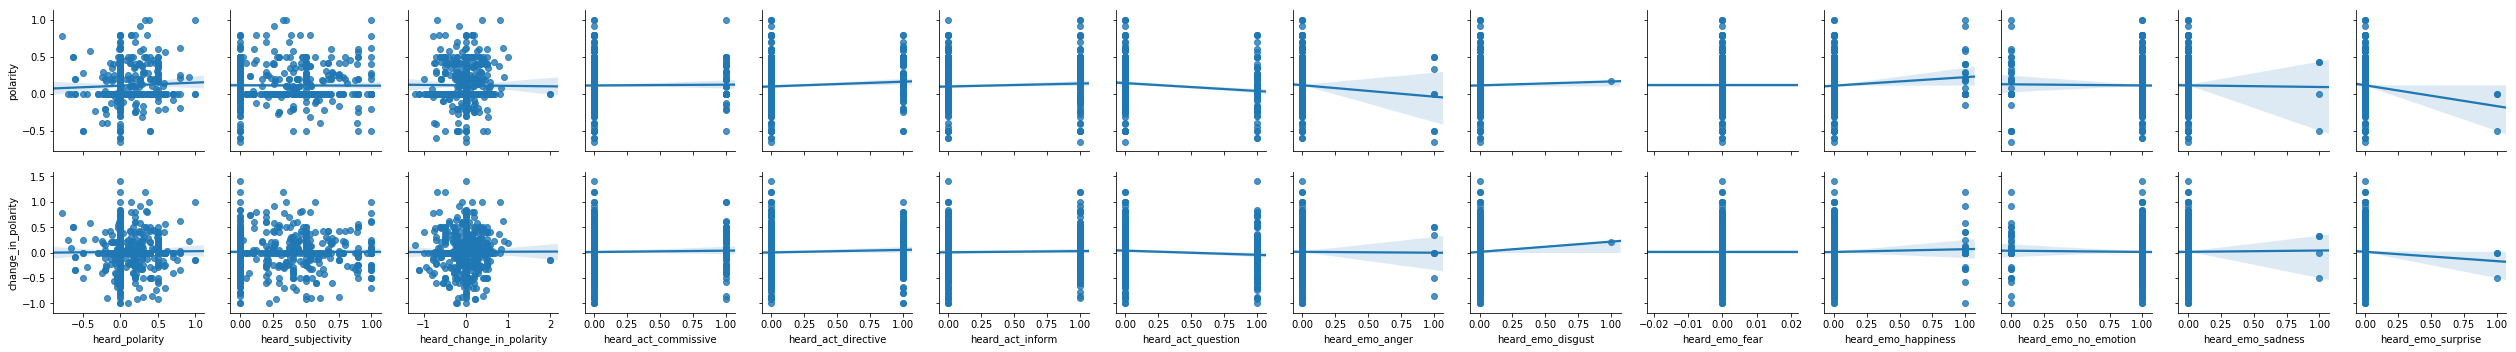

health


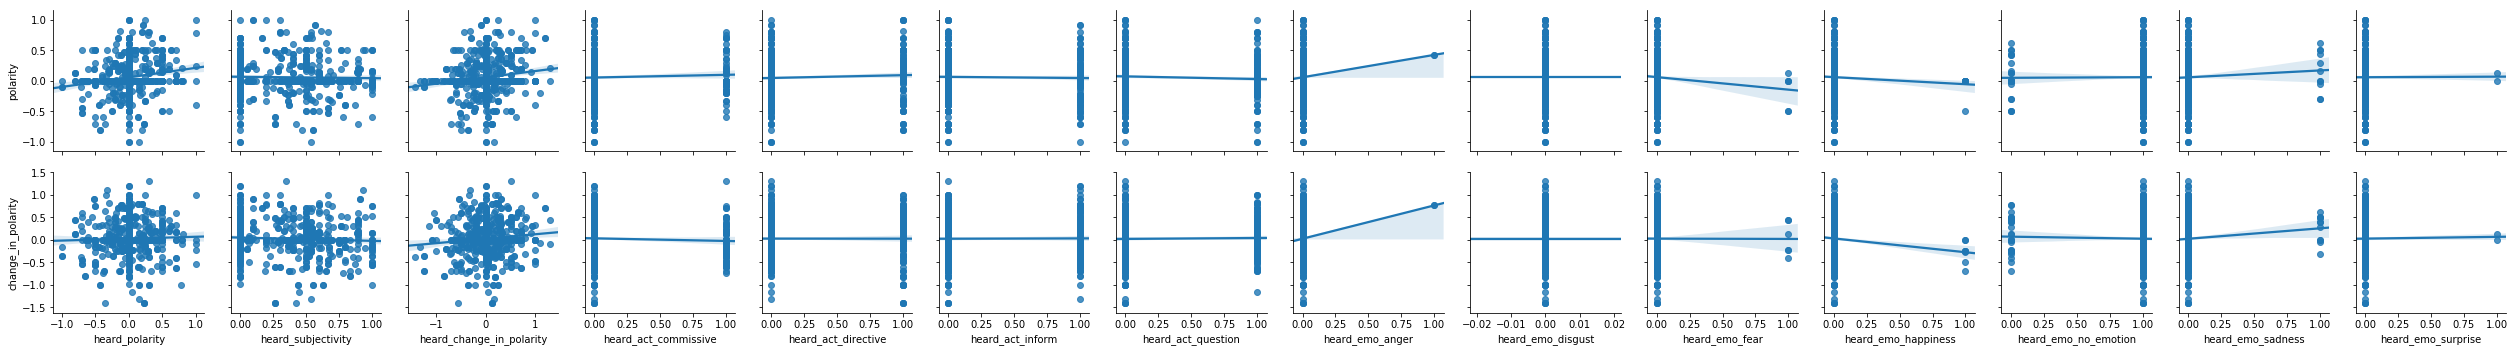

work


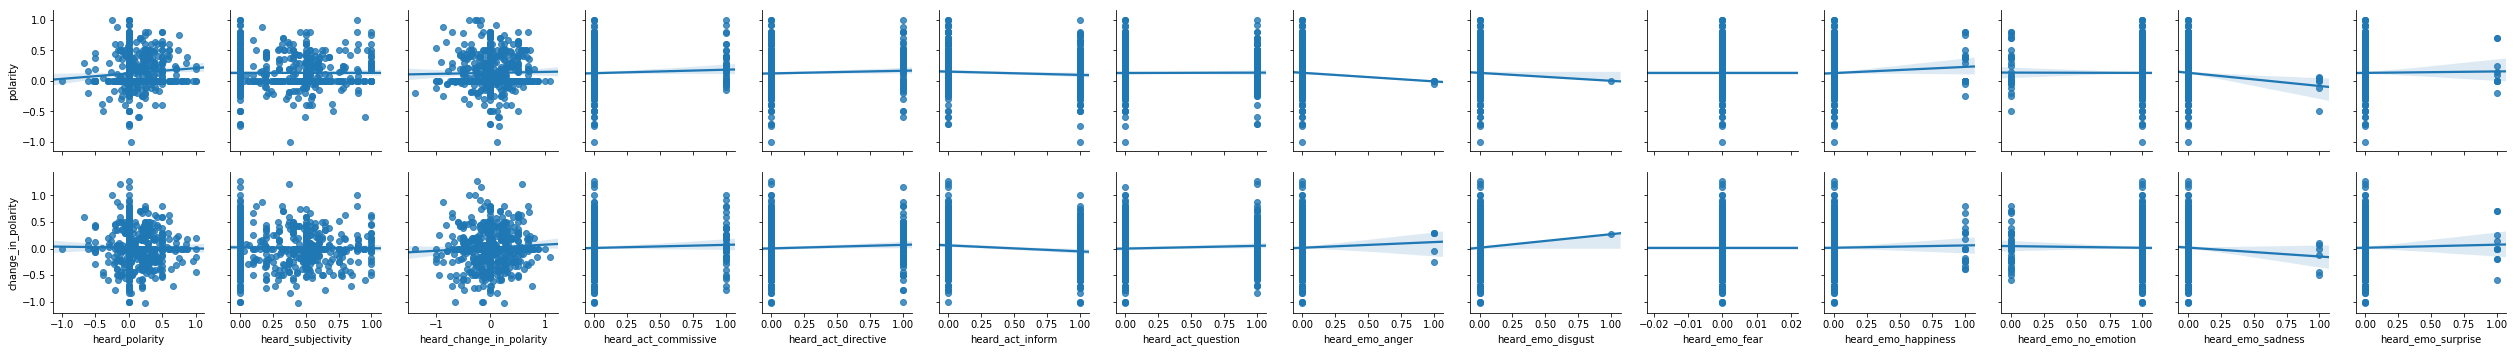

politics


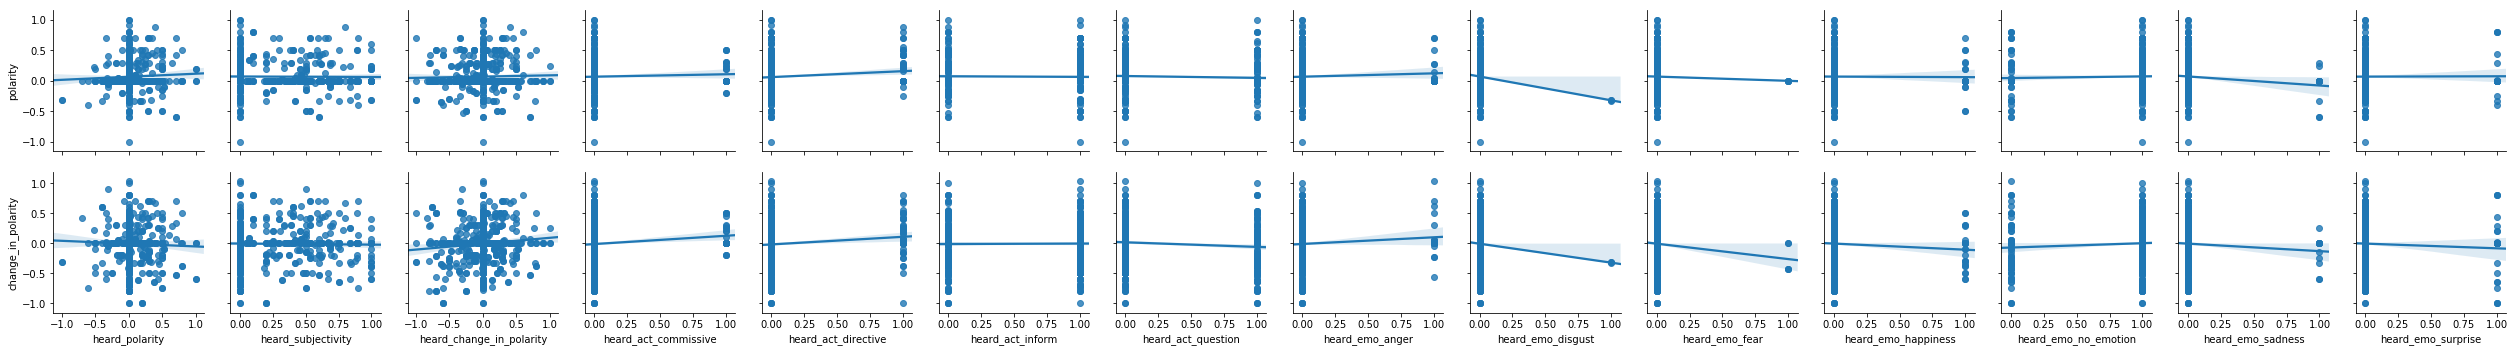

finance


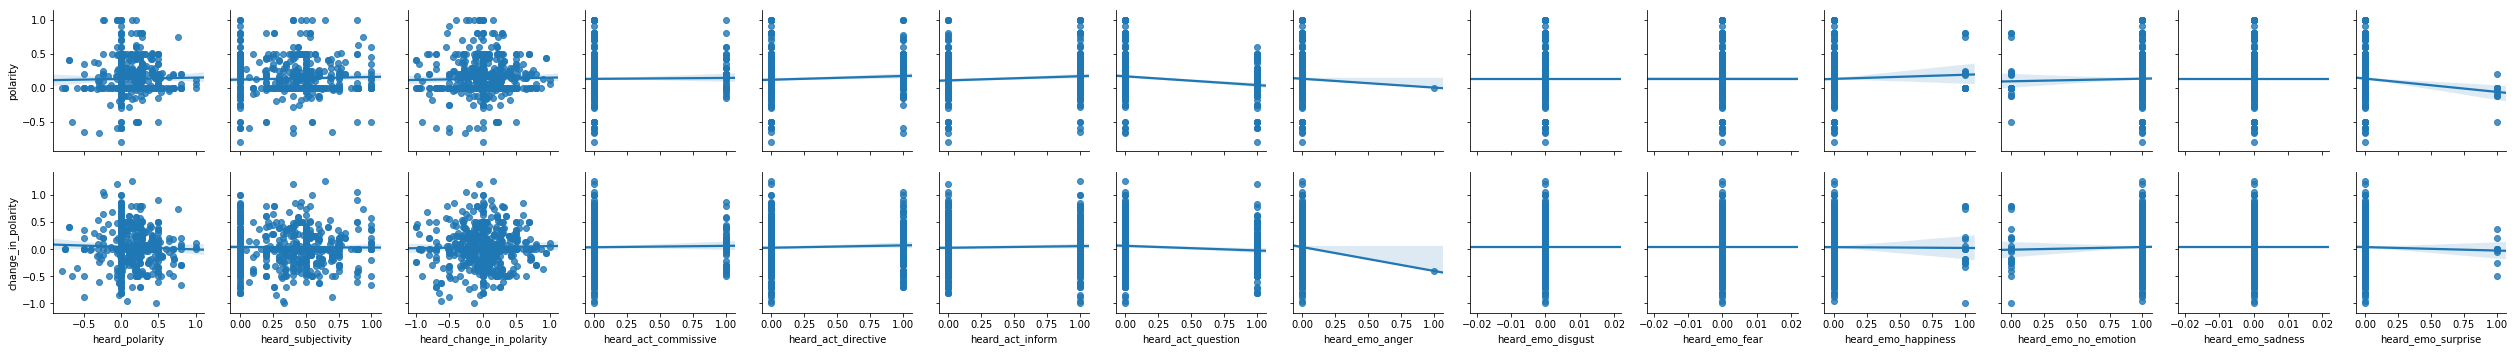

In [120]:
for topic in topics:
    print(topic)
    corrplot(train[train['topic'] == topic].sample(1000, replace=True))
    plt.show()

# Archived notes

### The parser suggested by Loris was not random if you look at the topic distribution

Just taking a brief look at the topic distribution. It appears that it's not even for each test set. 

In [3]:
train['topic'].unique(), validation['topic'].unique(), test['topic'].unique()

(array(['ordinary_life', 'school_life', 'culture_education',
        'attitude_emotion', 'relationship', 'tourism', 'health', 'work'],
       dtype=object),
 array(['work'], dtype=object),
 array(['work', 'politics', 'finance'], dtype=object))

Yeah the original dataset is simply sorted topics. I can't trust the topics. Not only that, they aren't really meaningful from one dataset to the next.

In [4]:
topics = pd.read_csv('data/ijcnlp_dailydialog/dialogues_topic.txt') # original unparsed
topics = topics['1']

print('Train dataset unique: {}\n'.format(topics[0:11118].unique()))
print('Validation dataset unique: {}\n'.format(topics[11118:12118].unique()))
print('Test dataset unique: {}\n'.format(topics[12118: 13118].unique()))

Train dataset unique: [1 2 3 4 5 6 7 8]

Validation dataset unique: [8]

Test dataset unique: [ 8  9 10]



##### Not going to use Topics for now. 